In [1]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 
from typing import Any, List, Tuple, Dict, Optional, Union
import numpy as np
import pandas as pd

import qubx
%qubxd dev

%load_ext autoreload
%autoreload 2

import qubx.pandaz.ta as pta
from qubx.data.readers import (
    CsvStorageDataReader, AsPandasFrame, AsOhlcvSeries, AsQuotes, RestoreTicksFromOHLC, AsTimestampedRecords,
)

from qubx.core.series import OHLCV, IndicatorOHLC, TimeSeries
from qubx.ta.indicators import (pewma, pewma_outliers_detector, psar, atr, swings)

from qubx.core.series import TimeSeries, Indicator, IndicatorOHLC, OHLCV, Bar
from qubx.core.utils import time_to_str
from scipy.special.cython_special import ndtri

def norm_pdf(x): return np.exp(-x ** 2 / 2) / np.sqrt(2 * np.pi)

r = CsvStorageDataReader('../tests/data/csv/')
ohlc = r.read('SOLUSDT', start='2024-04-01', stop='+24h', transform=AsOhlcvSeries('1Min', 'ms'))

ohlc_p = ohlc.pd()
qs = ohlc.close
ps = ohlc_p['close']

 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


# PEWMA

## Pewma test 

In [165]:
if 0:
    class Pewma(Indicator):

        _mean: float
        _vstd: float
        _var: float

        mean: float
        vstd: float
        var: float

        def _store(self):
            self.mean = self._mean
            self.vstd = self._vstd
            self.var = self._var

        def _restore(self):
            self._mean = self.mean
            self._vstd = self.vstd
            self._var = self.var

        def __init__(self, name, series, alpha, beta, T):
            self.alpha = alpha 
            self.beta = beta
            self.T = T

            # - local variables
            self._i = 0
            self.std = TimeSeries('std', series.timeframe, series.max_series_length)
            super().__init__(name, series)

        def _get_alpha(self, p_t):
            if self._i - 1 > self.T:
                return self.alpha * (1.0 - self.beta * p_t)
            return 1.0 - 1.0 / (self._i)

        def calculate(self, time, x,  new_item_started):

            if len(self.series) <= 1:
                self._mean = x
                self._vstd = 0.0
                self._var = 0.0
                self._store()
                self.std.update(time, self.vstd)
                return self.mean

            if new_item_started:
                self._i += 1
                self._restore()
            else:
                self._store()

            diff = x - self.mean
            # prob of observing diff
            p_t = norm_pdf(diff / self.vstd) if self.vstd != 0.0 else 0.0  

            # weight to give to this point
            a_t = self._get_alpha(p_t)  
            incr = (1.0 - a_t) * diff
            self.mean += incr
            self.var = a_t * (self.var + diff * incr)
            self.vstd = np.sqrt(self.var)
            self.std.update(time, self.vstd)

            return self.mean

    def pewma(series:TimeSeries, alpha: float, beta: float, T:int=30): return Pewma.wrap(series, alpha, beta, T)

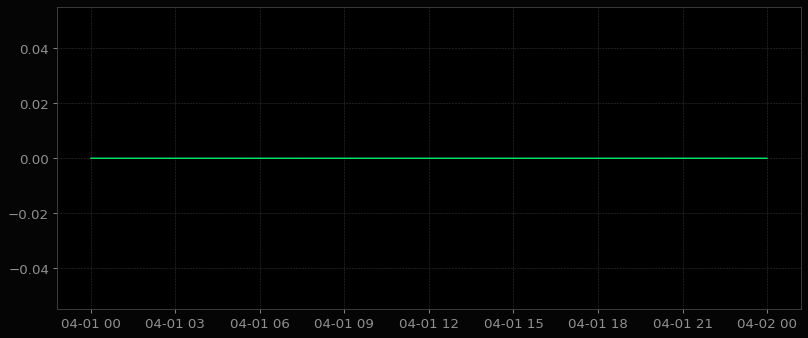

In [166]:
ohlc = r.read('SOLUSDT', start='2024-04-01', stop='+24h', transform=AsOhlcvSeries('1Min', 'ms'))

p0 = pta.pwma(ohlc.close.pd(), 0.99, 0.01, 10)
p1 = pewma(ohlc.close, 0.99, 0.01, 10)

p2 = pewma_outliers_detector(ohlc.close, 0.99, 0.01, 10)

plt.plot(p1.pd() - p0.Mean)
plt.plot(p1.std.pd() - p0.Std)

# plt.plot(p0.Mean - p2.pd())

# plt.plot(p1.std.pd())
# plt.plot(p0.Std)

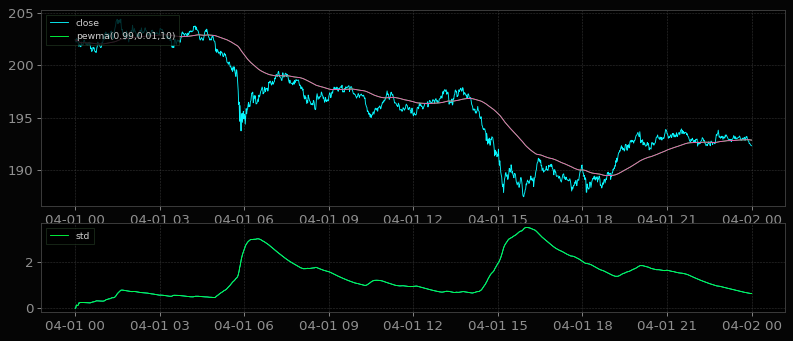

In [160]:
sbp(31,1,r=2)
qs.plot()
p1.plot()
plt.plot(p0.Mean)
sbp(31,3)
plt.plot(p0.Std)
p1.std.plot()


In [162]:
# abs(np.mean(p1.pd() - p0.Mean)) < 1e-3
abs(np.mean(p1.std.pd() - p0.Std)) < 1e-9

True

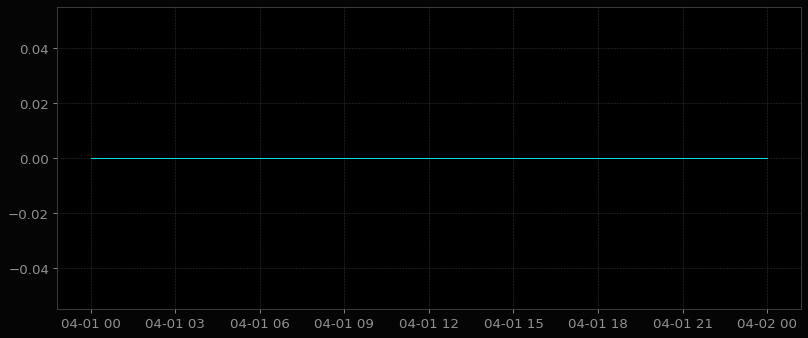

In [154]:
ohlc10 = OHLCV("Test", "30Min")
v10 = pewma(ohlc10.close, 0.9, 0.2, 1)
for b in ohlc[::-1]:
    ohlc10.update_by_bar(b.time, b.open, b.high, b.low, b.close, b.volume)
e10 = pta.pwma(ohlc10.close.pd(), 0.9, 0.2, 1)
plt.plot(v10.pd() - e10.Mean)

## pwma_outliers_detector

In [165]:
if 0:
    class PewmaOutliersDetector(Indicator):
        def __init__(self, name, series, alpha, beta, T, threshold):
            self.alpha = alpha 
            self.beta = beta
            self.T = T
            self.threshold = threshold

            # - series
            self.upper = TimeSeries('uba', series.timeframe, series.max_series_length)
            self.lower = TimeSeries('lba', series.timeframe, series.max_series_length)
            self.s = TimeSeries('std', series.timeframe, series.max_series_length)
            self.outliers = TimeSeries('outliers', series.timeframe, series.max_series_length)

            # - local variables
            self._i = 0
            self._z_thr = ndtri(1 - threshold / 2)

            super().__init__(name, series)

        def _store(self):
            self.mean = self._mean
            self.std = self._std
            self.variance = self._variance

        def _restore(self):
            self._mean = self.mean
            self._std = self.std
            self._variance = self.variance

        def _get_alpha(self, p_t):
            if self._i + 1 >= self.T:
                return self.alpha * (1.0 - self.beta * p_t)
            return 1.0 - 1.0 / (self._i + 1)

        def _get_mean(self, x, alpha_t):
            return alpha_t * self.mean + (1.0 - alpha_t) * x

        def _get_variance(self, x, alpha_t):
            return alpha_t * self.variance + (1.0 - alpha_t) * np.square(x)

        def _get_std(self, variance, mean):
            return np.sqrt(max(variance - np.square(mean), 0.0))

        def _get_p(self, x):
            z_t = ((x - self.mean) / self.std) if (self.std != 0 and not np.isnan(x)) else 0.0
            p_t = norm_pdf(z_t)
            return p_t

        def calculate(self, time, x, new_item_started):

            if len(self.series) <= 1:
                self._mean = x
                self._variance = x ** 2
                self._std = 0
                self._store()
                self.s.update(time, self.std)
                self.upper.update(time, x)
                self.lower.update(time, x)
                return self._mean

            if new_item_started:
                self._i += 1
                self._restore()
            else:
                self._store()

            p_t = self._get_p(x)
            alpha_t = self._get_alpha(p_t)
            self.mean = self._get_mean(x, alpha_t)
            self.variance = self._get_variance(x, alpha_t)
            self.std = self._get_std(self.variance, self.mean)
            ub = self.mean + self._z_thr * self.std
            lb = self.mean - self._z_thr * self.std

            self.upper.update(time, ub)
            self.lower.update(time, lb)
            self.s.update(time, self.std)
    
            return self.mean

    def pewma_outliers_detector(series:TimeSeries, alpha: float, beta: float, T:int=30, threshold=0.05): return PewmaOutliersDetector.wrap(series, alpha, beta, T, threshold)

### Test on formed bars

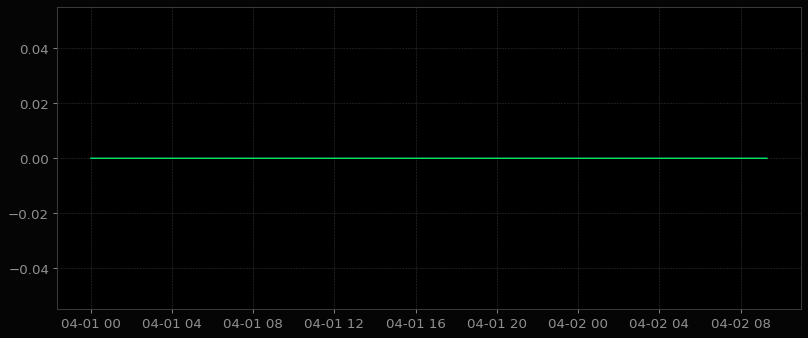

In [167]:
ohlc = r.read('SOLUSDT', start='2024-04-01', stop='+2d', transform=AsOhlcvSeries('1Min', 'ms'))
t0 = pta.pwma_outliers_detector(ohlc.close.pd(), 0.9, 0.2, 30)
t1 = pewma_outliers_detector(ohlc.close, 0.9, 0.2, 30)
plt.plot(t0.m - t1.pd())
plt.plot(t0.s - t1.s.pd())

In [ ]:
plt.plot(t0.m, lw=5)
plt.plot(t0.l, lw=5)
plt.plot(t0.u, lw=5)

qs.plot()
t1.plot()
t1.upper.plot()
t1.lower.plot()

In [ ]:
# plt.plot(t1.outliers)
t1.outliers.plot()
plt.plot(t0.outliers)

### Test streamed data

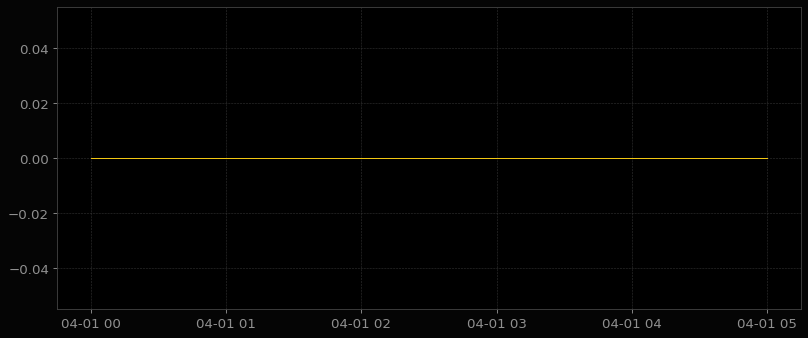

In [170]:
ohlc = r.read('SOLUSDT', start='2024-04-01', stop='+300Min', transform=AsOhlcvSeries('1Min', 'ms'))

_params = (0.9, 0.5, 5)
ohlc10, ohlc11= OHLCV("Test", "15Min"), OHLCV("Test", "15Min")
v10 = pewma_outliers_detector(ohlc10.close, *_params)

for b in ohlc[::-1]:
    ohlc10.update_by_bar(b.time, b.open, b.high, b.low, b.close, b.volume)
    ohlc11.update_by_bar(b.time, b.open, b.high, b.low, b.close, b.volume)

e10 = pta.pwma_outliers_detector(ohlc10.close.pd(), *_params)
e11 = pewma_outliers_detector(ohlc11.close, *_params).pd()

plt.plot(e10.m - e11)
plt.plot(v10.pd() - e10.m)
plt.plot(v10.upper.pd() - e10.u)
plt.plot(v10.lower.pd() - e10.l)

In [ ]:
v10

In [ ]:
e10.m

# PSAR

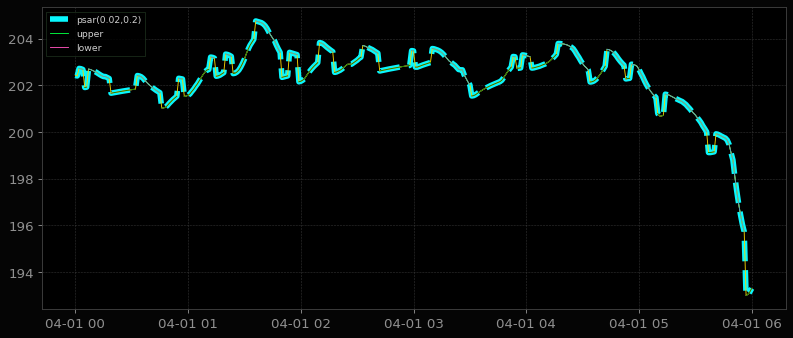

In [3]:
ohlc = r.read("SOLUSDT", start="2024-04-01", stop="+360Min", transform=AsOhlcvSeries("1Min", "ms"))
v = psar(ohlc)
e = pta.psar(ohlc.pd())
v.plot(ls="--", lw=5)
v.upper.plot()
v.lower.plot()

plt.plot(e.psar)
plt.plot(e.up)
plt.plot(e.down)

In [8]:
ohlc10 = OHLCV('test', '5Min')
v10 = psar(ohlc10)

for b in ohlc[::-1]:
    ohlc10.update_by_bar(b.time, b.open, b.high, b.low, b.close, b.volume)
e10 = pta.psar(ohlc10.pd())


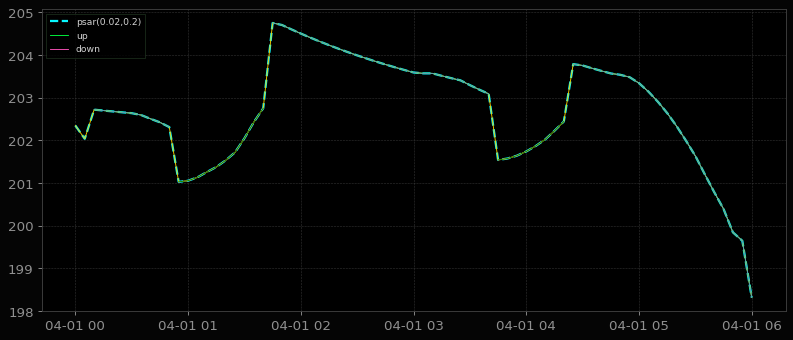

In [9]:
v10.plot(ls='--', lw=2)
v10.up.plot()
v10.down.plot()

plt.plot(e10.psar);
plt.plot(e10.up);
plt.plot(e10.down);


# ATR

In [61]:
# - test in py first
if 0:
    from qubx.ta.indicators import pewma, ema, sma, kama, tema, dema

    _smoothers = {f.__name__: f for f in [pewma, ema, sma, kama, tema, dema]}

    def smooth(series, smoother, *args, **kwargs):
        _sfn = _smoothers.get(smoother)
        if _sfn is None:
            raise ValueError(f"Smoother {smoother} not found!")
        return _sfn(series, *args, **kwargs)

    class Atr(IndicatorOHLC):
        def __init__(self, name, series, period, smoother, percentage):
            self.percentage = percentage
            self.tr = TimeSeries("tr", series.timeframe, series.max_series_length)
            self.ma = smooth(self.tr, smoother, period)
            super().__init__(name, series)

        def calculate(self, time, bar, new_item_started):

            if len(self.series) <= 1:
                return np.nan

            c1 = self.series[1].close
            h_l = abs(bar.high - bar.low)
            h_pc = abs(bar.high - c1)
            l_pc = abs(bar.low - c1)
            self.tr.update(time, max(h_l, h_pc, l_pc))
            return (100 * self.ma[0] / c1) if self.percentage else self.ma[0]

    def atr(series: OHLCV, period: int = 14, smoother="sma", percentage: bool = False):
        if not isinstance(series, OHLCV):
            raise ValueError("Series must be OHLCV !")
        return Atr.wrap(series, period, smoother, percentage)

In [4]:
ohlc = r.read("SOLUSDT", start="2024-04-01", stop="+5d", transform=AsOhlcvSeries("1Min", "ms"))
v = atr(ohlc, 14, "sma", percentage=False)
e = pta.atr(ohlc.pd(), 14, "sma", percentage=False)

In [1]:
(v.pd() - e).dropna().sum()

NameError: name 'v' is not defined

# Swings

In [2]:
if 0:
    from qubx.ta.indicators import psar


    class Swings(IndicatorOHLC):
        _min_l: float
        _min_t: int
        _max_h: float
        _max_t: int
        tops: TimeSeries
        tops_detection_lag: TimeSeries
        bottoms: TimeSeries
        bottoms_detection_lag: TimeSeries

        def __init__(self, name, series, trend_indicator, **indicator_args):
            self.ser = OHLCV("base", series.timeframe, series.max_series_length)
            self.trend = trend_indicator(self.ser, **indicator_args)

            self.tops = TimeSeries("tops", series.timeframe, series.max_series_length)
            self.tops_detection_lag = TimeSeries("tops_lag", series.timeframe, series.max_series_length)

            self.bottoms = TimeSeries("bottoms", series.timeframe, series.max_series_length)
            self.bottoms_detection_lag = TimeSeries("bottoms_lag", series.timeframe, series.max_series_length)

            self._min_l = +np.inf
            self._max_h = -np.inf
            self._max_t = 0
            self._min_t = 0
            super().__init__(name, series)

        def calculate(self, time, bar, new_item_started):
            self.ser.update_by_bar(time, bar.open, bar.high, bar.low, bar.close, bar.volume)
            _t = np.nan

            if len(self.trend.upper) > 0:
                _u = self.trend.upper[0]
                _d = self.trend.lower[0]

                if not np.isnan(_u):
                    if self._max_t > 0:
                        self.tops.update(self._max_t, self._max_h)
                        self.tops_detection_lag.update(self._max_t, time - self._max_t)

                    if bar.low <= self._min_l:
                        self._min_l = bar.low
                        self._min_t = time

                    self._max_h = -np.inf
                    self._max_t = 0
                    _t = -1
                elif not np.isnan(_d):
                    if self._min_t > 0:
                        self.bottoms.update(self._min_t, self._min_l)
                        self.bottoms_detection_lag.update(self._min_t, time - self._min_t)

                    if bar.high >= self._max_h:
                        self._max_h = bar.high
                        self._max_t = time

                    self._min_l = +np.inf
                    self._min_t = 0
                    _t = +1

            return _t

        def get_current_trend_end(self) -> Tuple[pd.Timestamp|None, float|None]:
            if np.isfinite(self._min_l):
                return pd.Timestamp(self._min_t, 'ns'), self._min_l
            elif np.isfinite(self._max_h):
                return pd.Timestamp(self._max_t, 'ns'), self._max_h
            return (None, None)

        def pd(self) -> pd.DataFrame:
            _t, _d = self.get_current_trend_end()
            tps, bts = self.tops.pd(), self.bottoms.pd()
            tpl, btl = self.tops_detection_lag.pd(), self.bottoms_detection_lag.pd()
            if _t is not None:
                if bts.index[-1] < tps.index[-1]:
                    bts = srows(bts, pd.Series({_t: _d}))
                    btl = srows(btl, pd.Series({_t: 0}))  # last lag is 0
                else:
                    tps = srows(tps, pd.Series({_t: _d}))
                    tpl = srows(tpl, pd.Series({_t: 0})) # last lag is 0

            # - convert tpl / btl to timedeltas
            tpl, btl = tpl.apply(lambda x: pd.Timedelta(x, unit='ns')), btl.apply(lambda x: pd.Timedelta(x, unit='ns'))

            eid = pd.Series(tps.index, tps.index)
            mx = scols(bts, tps, eid, names=["start_price", "end_price", "end"])
            dt = scols(mx["start_price"], mx["end_price"].shift(-1), mx["end"].shift(-1))  # .dropna()
            dt = dt.assign(
                delta = dt["end_price"] - dt["start_price"], 
                spotted = pd.Series(bts.index + btl, bts.index)
            )

            eid = pd.Series(bts.index, bts.index)
            mx = scols(tps, bts, eid, names=["start_price", "end_price", "end"])
            ut = scols(mx["start_price"], mx["end_price"].shift(-1), mx["end"].shift(-1))  # .dropna()
            ut = ut.assign(
                delta = ut["end_price"] - ut["start_price"], 
                spotted = pd.Series(tps.index + tpl, tps.index)
            )

            return scols(ut, dt, keys=["DownTrends", "UpTrends"])


    def swings(series: OHLCV, trend_indicator, **indicator_args):
        if not isinstance(series, OHLCV):
            raise ValueError("Series must be OHLCV !")
        return Swings.wrap(series, trend_indicator, **indicator_args)

## Test1

In [5]:
ohlc = r.read("SOLUSDT", start="2024-04-01 00:00", stop="+24h", transform=AsOhlcvSeries("15Min", "ms"))
v = swings(ohlc, psar, iaf=0.1, maxaf=1)
e = pta.swings(ohlc.pd(), pta.psar, iaf=0.1, maxaf=1)

_ps = psar(ohlc, iaf=0.1, maxaf=1)
# scols(_ps.upper.pd(), _ps.lower.pd())
# v.pd()

In [45]:
# eid, tpl, btl, tps, bts = v.pd()

# mx = scols(bts, tps, eid, names=["start_price", "end_price", "end"])
# dt = scols(mx["start_price"], mx["end_price"].shift(-1), mx["end"].shift(-1))  # .dropna()


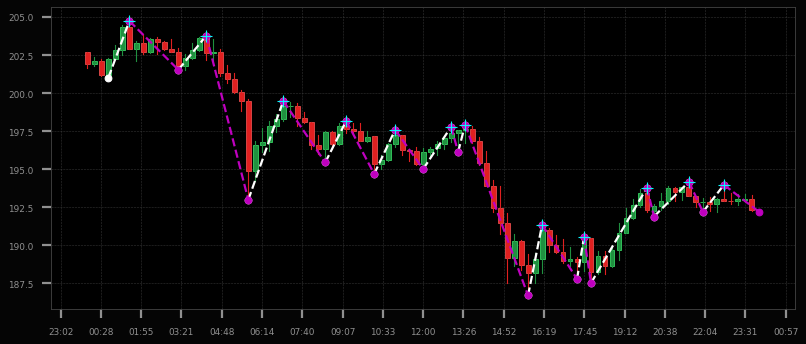

In [8]:
ohlc_plot(ohlc.pd())
plot_trends(v.pd())
plt.plot(v.tops.pd(), '+', ms=10)


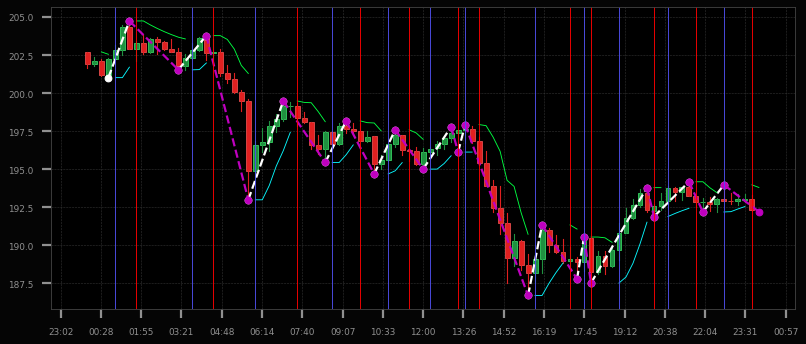

In [9]:
ohlc_plot(ohlc.pd())
plot_trends(e)
plt.plot(_ps.lower.pd())
plt.plot(_ps.upper.pd())

[plt.axvline(l) for l in v.pd().UpTrends.dropna().spotted]
[plt.axvline(l, c='r') for l in v.pd().DownTrends.dropna().spotted];

## Test2

In [6]:
ohlc = r.read("SOLUSDT", start="2024-04-01", stop="+24h", transform=AsOhlcvSeries("15Min", "ms"))

ohlc10 = OHLCV("test", "60Min")
v10 = swings(ohlc10, psar, iaf=0.1, maxaf=1)

for b in ohlc[::-1]:
    ohlc10.update_by_bar(b.time, b.open, b.high, b.low, b.close, b.volume)

e10 = pta.swings(ohlc10.pd(), pta.psar, iaf=0.1, maxaf=1)

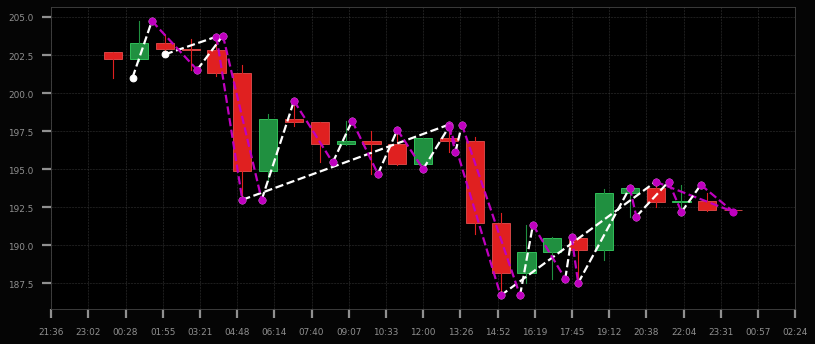

In [9]:
ohlc_plot(ohlc10.pd())
plot_trends(v10.pd())
plot_trends(v.pd())

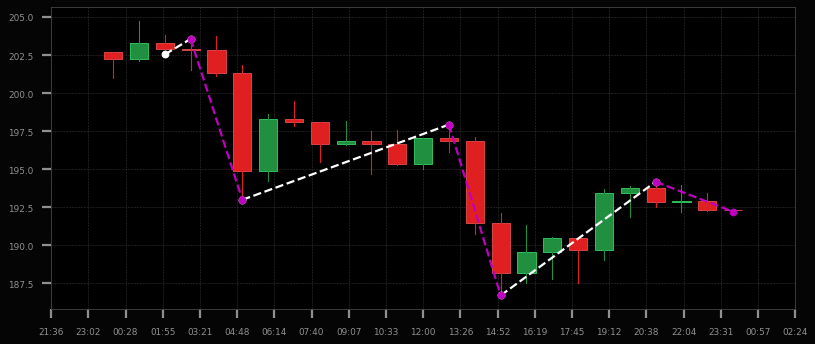

In [8]:
ohlc_plot(ohlc10.pd())
plot_trends(e10)